# Rapport TME 1-3 AMAL

Découverte de PyTorch

# TME 1 : Définition de fonctions en PyTorch

In [1]:
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets 
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
import datetime
from torch.autograd import Function, gradcheck
import datamaestro
import numpy as np
import torch.nn.functional as F

## Classes Context, MSE et Linear

In [68]:
class Context:
    """
    Un objet contexte très simplifié pour simuler PyTorch
    Un contexte différent doit être utilisé à chaque forward
    """
    def __init__(self):
        self._saved_tensors = ()
    def save_for_backward(self, *args):
        self._saved_tensors = args
    @property
    def saved_tensors(self):
        return self._saved_tensors


class MSE(Function):
    """Implementation de la fonction MSE"""
    @staticmethod
    def forward(ctx, yhat, y):
        ## Garde les valeurs nécessaires pour le backwards
        ctx.save_for_backward(yhat, y)

        return torch.sum((yhat-y)**2)/y.shape[0]

    @staticmethod
    def backward(ctx, grad_output):
        ## Calcul du gradient du module par rapport a chaque groupe d'entrées
        yhat, y = ctx.saved_tensors
        q = y.shape[0]
        tmp = 2/q*grad_output*(yhat-y)
        return tmp, -tmp


class Linear(Function):
    """Implémentation du linéaire"""
    @staticmethod
    def forward(ctx,X,W,b):
        ctx.save_for_backward(X,W)
        return X @ W + b
    
    @staticmethod
    def backward(ctx,grad_output):
        X, W = ctx.saved_tensors
        return grad_output @ W.T, X.T @ grad_output, grad_output.sum(0).reshape(1,-1)

## Test sur des données random

Text(0, 0.5, 'loss')

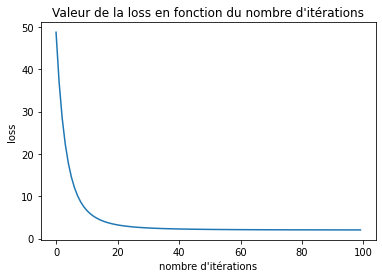

In [69]:
### Les données supervisées ###
x = torch.randn(50, 13)
y = torch.randn(50, 3)

### Les paramètres du modèle à optimiser ###
w = torch.randn(13, 3)
b = torch.randn(3)

epsilon = 0.05

ctxLinear = Context()
ctxMSE = Context()

#### Descente de Gradient ####

liste_loss = []
writer = SummaryWriter()
for n_iter in range(100):
    # Calcul du forward (loss)
    yhat = Linear.forward(ctxLinear,x,w,b)
    loss = MSE.forward(ctxMSE,yhat,y)

    writer.add_scalar('Loss/train', loss, n_iter)
    liste_loss.append(loss)
    
    # Calcul du backward (grad_w, grad_b)
    _, grad_w, grad_b = Linear.backward(ctxLinear,MSE.backward(ctxMSE,1)[0])
    
    # Mise à jour des paramètres du modèle
    w = w - epsilon*grad_w
    b = b - epsilon*grad_b
    
plt.figure()
plt.plot(liste_loss)
plt.title("Valeur de la loss en fonction du nombre d'itérations")
plt.xlabel("nombre d'itérations")
plt.ylabel("loss")

# TME 2 : Graphe de calcul, autograd et modules

## Préparation des données Boston Housing

In [2]:
### Chargement des données ###
data = datamaestro.prepare_dataset("edu.uci.boston")
colnames, datax, datay = data.data()
datax = torch.tensor(datax,dtype=torch.float)
datay = torch.tensor(datay,dtype=torch.float).reshape(-1,1)

### Séparation en train/test ###
n,_ = datax.shape
ind_train = np.random.choice(range(n),int(n*0.8),replace=False)
ind_test = list(set(range(n))-set(ind_train))

xtrain = datax[ind_train]
xtest = datax[ind_test]
ytrain = datay[ind_train]
ytest = datay[ind_test]

### Normalisation des données ###
mean_train = xtrain.mean()
std_train = xtrain.std()

xtrain = (xtrain - mean_train)/std_train
xtest = (xtest - mean_train)/std_train

## Descente de gradient avec autograd : batch, stochastique ou mini-batch

La descente du Gradient est un algorithme qui a pour objective de minimiser une fonction avec une approche itérative.
<br>
Il existe plusieurs type de descente de gradient:
<br>
Stochastique: Tirage aléatoire d'un exemple ensuite mise à jour des poids pour ce dernier. Et on réitère.
<br>
Batch: Mise à jour des poids sur l'ensemble des exemples d'aprentissage.
<br>
Mini-Batch: Compromis entre les deux méthodes précédentes. On mets à jour les poids sur des sous-ensembles des exemples d'apprentissage.


In [3]:
type_desc = 'stochastique' # choix du type de descente : 'batch', 'stochastique', 'mini-batch'

epsilon = 0.001
nb_iter = 300
size_batch = 20 # taille du batch pour le mini-batch

w = torch.randn((xtrain.shape[1],ytrain.shape[1]), requires_grad=True)
b = torch.randn(ytrain.shape[1], requires_grad=True)

writer = SummaryWriter()
loss_train = []
loss_test = []

for n_iter in range(nb_iter):

    if type_desc == 'batch':
        ind = range(len(xtrain))
        
    elif type_desc == 'stochastique':
        ind = np.random.randint(xtrain.shape[0])
    
    elif type_desc == 'mini-batch':
        ind = np.random.choice(xtrain.shape[0],size_batch,replace=False)
    
    yhat = xtrain[ind] @ w + b
    loss = torch.mean((yhat-ytrain[ind])**2)
    
    writer.add_scalar('Loss/train', loss, n_iter)
    writer.add_scalar('Loss/test', torch.mean((xtest @ w + b-ytest)**2), n_iter)
    
    loss_train.append(loss)
    loss_test.append(torch.mean((xtest @ w + b-ytest)**2))
    
    loss.backward()
    
    with torch.no_grad():
        w -= epsilon*w.grad
        b -= epsilon*b.grad
        w.grad.zero_()
        b.grad.zero_()

| **batch** | **mini-batch taille 20** | **stochastique** |
| :------------: | :------------: | :------------: |
| ![](Img/tme2_batch.png) | ![](Img/tme2_mini-batch.png) | ![](Img/tme2_stochastique.png) |

Stochastique: La loss n'est pas très "smooth" en train car la mise à jour des paramètres se fait seulement sur un seul exemple à chaque itération.
<br>
Plus la taille du batch est grande, plus la loss est smooth. Le temps d'entraînement est cependant plus long.

## Descente de gradient avec optimiseur et module

In [41]:
h=10
epsilon = 0.005
nb_iter = 400

### Modele ###
m1 = torch.nn.Linear(xtrain.shape[1],h)
act = torch.nn.ReLU()
m2 = torch.nn.Linear(h,1)
mse = torch.nn.MSELoss()
model = torch.nn.Sequential(m1, act, m2)

### Optimiseur ###
optim = torch.optim.SGD(params=[m1.weight,m1.bias,m2.weight,m2.bias],lr=epsilon)
optim.zero_grad()

### Paramètres ###
w = torch.nn.Parameter(torch.randn(xtrain.shape[1],ytrain.shape[1]))
b = torch.nn.Parameter(torch.randn(ytrain.shape[1]))

loss_train = []
loss_test = []

for n_iter in range(nb_iter):
    
    yhat = model(xtrain)
    loss = mse(yhat,ytrain) # Calcul du Coût
    
    loss_train.append(loss)
    
    loss.backward() # Rétropropagation
    optim.step()
    optim.zero_grad()

    with torch.no_grad():
        loss_test.append(mse(model(xtest),ytest)) # loss en test

| **eps=0.005** | **eps=0.001** |
| :------------: | :------------: |
| ![](Img/tme2_2_eps=0.005.png) | ![](Img/tme2_2_eps=0.001.png) |

La fonction d'activation utilisée ici est la ReLU (et non pas Tanh).
<br>
Avec eps=0.005, le modèle semble avoir atteint un minimum local mais s'en écarte à cause du pas de gradient trop élevé (d'où les petits pics en 250 et 350).

Mis à part du conteneur "Sequential", il existe d'autre types de conteneurs, dans ces derniers les modules peuvent être contenu dans des listes, des dictionnaires. Les paramètres sont aussi mises respectivement dans des listes et des dictionnnaires.

# TME 3 : Définition de fonctions en pyTorch

## Classes MonDataset, AutoEncoder et State

In [142]:
class MonDataset(Dataset):
    def __init__(self,X,y):
        self.X = X.float().reshape(len(X),-1)
        self.X /= 255
        self.y = y
    def __getitem__(self,index):
        return self.X[index], self.y[index]
    def __len__(self):
        return len(self.X)

class AutoEncoder(nn.Module):
    def __init__(self,D_in,D_h):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Linear(D_in,D_h,bias=False)
        self.act1 = nn.ReLU()
        self.act2 = nn.Sigmoid()
        
    def forward(self,x):
        encoded = self.act1(self.encoder(x))
        return self.act2(F.linear(encoded,self.encoder.weight.t()))  

class State:
    def __init__(self,model,optim):
        self.model = model
        self.optim = optim
        self.epoch, self.iteration = 0, 0

L'avantage du partage des poids dans l'auto-encodeur est qu'il y a moins de paramètres à apprendre.

## Chargement des données

In [220]:
### Chargement des données ###
mnist_train = torchvision.datasets.MNIST('/tmp/mnist/data', train=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST('/tmp/mnist/data', train=False, transform=transforms.ToTensor())

train_images, train_labels = mnist_train.train_data, mnist_train.train_labels
test_images, test_labels = mnist_test.test_data, mnist_test.test_labels

train = MonDataset(train_images,train_labels)
test = MonDataset(test_images,test_labels)

## Test de l'auto-encodeur

In [221]:
### Paramètres ###
batch_size = 128
D_in, D_h = len(train[0][0]), 100
lr = 0.005
nb_epoch = 4

### DataLoader ###
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)       
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True, drop_last=True)

savepath = Path('autoencoder.pch')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
writer = SummaryWriter("runs/runs"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

if savepath.is_file():
    with savepath.open('rb') as fp:
        state = torch.load(fp)
else:
    model = AutoEncoder(D_in,D_h)
    model = model.to(device)
    optim = torch.optim.Adam(model.parameters(),lr=lr)
    loss_fn = nn.MSELoss()
    state = State(model,optim)

for epoch in range(state.epoch,nb_epoch):
    for x,y in train_loader: # pour chaque batch
        state.optim.zero_grad()
        x = x.to(device)
        xhat = model(x)
        loss = loss_fn(xhat,x)
        writer.add_scalar('Loss/train',loss,state.iteration)
        loss.backward()
        state.optim.step()
        state.iteration += 1
    
    with savepath.open("wb") as fp:
        state.epoch = epoch + 1
        torch.save(state,fp)

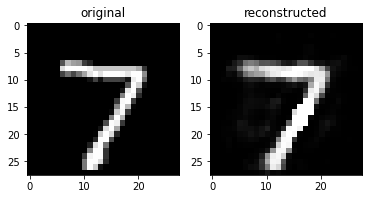

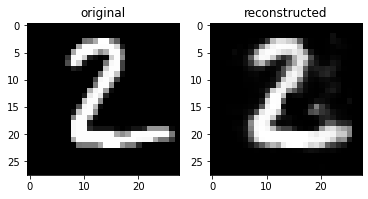

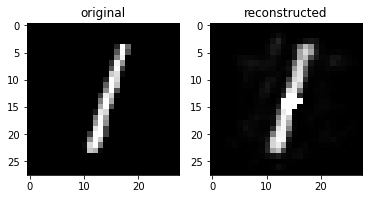

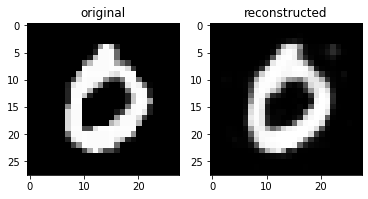

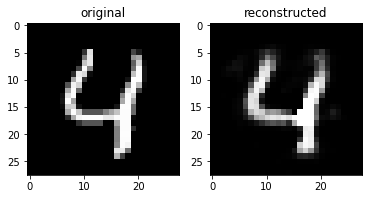

In [223]:
for i in range(5):
    fig, ax = plt.subplots(1, 2, figsize=(6,4))
    ax[0].imshow(test[i][0].view(28,28).numpy(),cmap='gray',)
    ax[0].set_title("original")
    ax[1].imshow(model(test[i][0]).view(28,28).detach().numpy(),cmap='gray')
    ax[1].set_title("reconstructed")

On obtient une petite valeur de loss (0.0124). L'optimiser Adam a permis une convergence bien plus rapide qu'avec l'optimiseur SGD. Les images reconstruites sont un peu floues, elles manquent un peu de précision, notamment les chiffres semblent s'étaler légèrement. Par exemple les chiffres 1, 2 et 4 est plus épais dans l'image recontruite.

## Embedding avec tensorboard

In [219]:
### Récupération des features sur 500 images des données de test ###
features = model.act1(model.encoder(test[:500][0]))

### Utilisation de tensorboard ###
writer = SummaryWriter()
writer.add_embedding(features, metadata=test[:500][1], label_img=test_images[:500].unsqueeze(1))

![](Img/tme3_embedding_umap.PNG)

On voit un regroupement de 6 au milieu, ainsi qu'un regroupement de 3 en bas à droite. De plus, on peut voir qu'il y a un regroupement de 1 en haut à droite, tandis qu'il y a un regroupement de 0 à l'opposé, en bas à gauche. Ces deux chiffres étant très différents, on a une bonne représentationNotre modèle semble donc avoir assez bien conservé les features importants des données.

## Interpolation des représentations

In [ ]:
### Choix images ###
img1 = test[2][0]
img2 = test[3][0]

### Encodage des images ###
z1 = model.encoder(img1)
z2 = model.encoder(img2)

### Affichage ###
fig, ax = plt.subplots(1, 11, figsize=(20,4))
l = np.linspace(0,1,11)
for i in range(11):
    z = l[i]*z1 + (1-l[i])*z2
    d = model.decoder(z)
    ax[i].imshow(d.view(28,28).detach().numpy(),cmap='gray')

**Entre 7 et 3 :**
![](Img/tme3_7_3.png)
**Entre 9 et 6 :**
![](Img/tme3_9_6.png)
**Entre 0 et 1 :**
![](Img/tme3_0_1.png)

On affiche le décodage de l'interpolation avec lambda variant avec un pas de 0.1. On peut voir la transition entre les deux chiffres.

## Highway Network

R.K.Srivastava, K.Greff, and J.Schmidhuber, Highway networks, 2015. https://arxiv.org/abs/1505.00387

In [66]:
class HighwayLayer(nn.Module):
    def __init__(self,in_size,out_size):
        super(HighwayLayer, self).__init__()
        self.H = nn.Linear(in_size,out_size)
        self.T = nn.Linear(in_size,out_size)
        self.actT = nn.Sigmoid()
        self.actH = nn.ReLU()
        self.X = nn.Linear(in_size,out_size) # pour changer la dimension si besoin
        
    def forward(self,input):
        h = self.actH(self.H(input))
        t = self.actT(self.T(input))
        x = self.X(input)
        return h*t + x*(1-t)
    
class HighwayNetwork(nn.Module):
    def __init__(self,in_size,out_size,list_h):
        super(HighwayNetwork, self).__init__()
        self.list_h = [in_size] + list_h + [out_size]
        self.hlayers = nn.ModuleList([HighwayLayer(self.list_h[i],self.list_h[i+1]) for i in range(len(self.list_h)-1)])
    
    def forward(self,x):
        for i in range(len(self.list_h)-1):
            x = self.hlayers[i](x)
        return x

## Test du Highway network dans le problème d'encodage/décodage des images

In [230]:
### Paramètres ###
batch_size = 128
D_in, D_h = len(train[0][0]), 256
lr = 0.001
nb_epoch = 1

### DataLoader ###
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)       
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True, drop_last=True)

savepath = Path('highway.pch')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
writer = SummaryWriter("runs/runs"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

if savepath.is_file():
    with savepath.open('rb') as fp:
        state = torch.load(fp)
else:
    model = HighwayNetwork(D_in,D_in,[392,256,128,256,392])
    model = model.to(device)
    optim = torch.optim.Adam(model.parameters(),lr=lr)
    loss_fn = nn.MSELoss()
    state = State(model,optim)

for epoch in range(state.epoch,nb_epoch):
    
    for x,y in train_loader:
        state.optim.zero_grad()
        x = x.to(device)
        xhat = model(x)
        loss = loss_fn(xhat,x)
        writer.add_scalar('Loss/train',loss,state.iteration)
        loss.backward()
        state.optim.step()
        state.iteration += 1
    
    with savepath.open("wb") as fp:
        state.epoch = epoch + 1
        torch.save(state,fp)

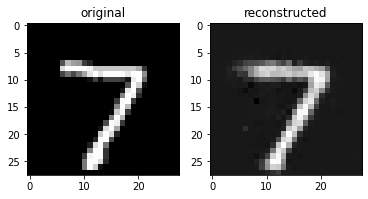

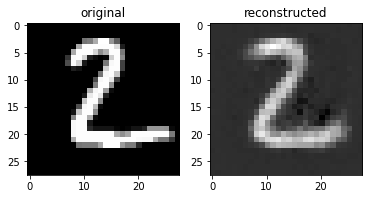

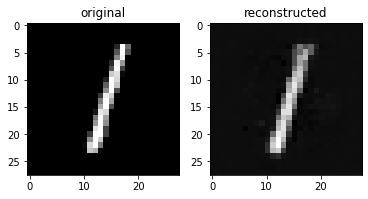

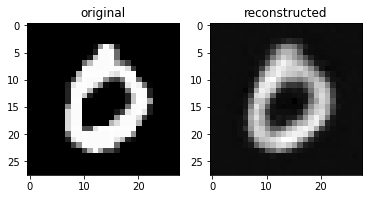

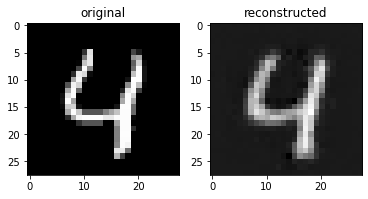

In [251]:
for i in range(5):
    fig, ax = plt.subplots(1, 2, figsize=(6,4))
    ax[0].imshow(test[i][0].view(28,28).numpy(),cmap='gray',)
    ax[0].set_title("original")
    ax[1].imshow(model(test[i][0]).view(28,28).detach().numpy(),cmap='gray')
    ax[1].set_title("reconstructed")

On obtient à la fin une valeur de loss très petite (0.0127). A première vue, les résultats ne semblent pas très satisfaisants : l'image reconstruite semble floue et les niveaux de gris semblent un peu décalés. Cependant, cela est peut-être dû à un problème d'affichage : en effet, la fonction imshow() de matplotlib normalise l'image en réalisant une mise à l'échelle dans laquelle la plus petite valeur est mise à 0, tandis que la plus grande valeur est mise à 1. Cela peut poser problème lorsque l'ensemble des pixels sont d'intensité proche ou lorsque un pixel a une valeur extrême. Appliquer une égalisation d'histogramme à l'image pourrait régler le problème.
<br>
Par exemple, dans l'image du chiffre 2, la valeur min de l'image reconstruite vaut -0.2960, tandis que sa valeur max vaut 1.3288.